# How to use CUPED

## Calculating the treatment effect

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import datetime
from dateutil.relativedelta import relativedelta

In [ ]:
df = pd.read_csv('fake_data.csv')

,user_id,group,revenue_pre,revenue_exp
0,cf7f6389-95e8-44b1-88d9-71a784d0eea3,control,126.174822,131.495757
1,6b129f09-fb5f-42df-bde3-a0daf9476c31,control,95.278575,105.803968
2,f5ce5d40-a918-482f-bd4a-27ade2af0d97,treatment,101.397369,101.787418
3,82592e1a-b6b7-42bf-a625-1fc138f92d3e,control,68.855613,56.851970
4,549b14a8-fc08-4224-bf8e-931a7a50e6ff,control,112.974435,101.960805
...,...,...,...,...
1958,074587da-a60a-4017-aa27-6d4c316efe71,treatment,80.804420,73.944887
1959,d1a843de-a1db-479f-9e23-65867cc57120,treatment,54.919574,79.652109
1960,c9e0f7e5-6c22-4434-9168-131e97841d9b,treatment,158.438671,141.914387
1961,c69dd04c-80c5-4c09-b961-ff188eb22a20,control,119.798094,101.634467


In [ ]:
# CUPED Treatment effect calculation

##1 CUPED transformed revenue

var_X = np.var(df['revenue_pre'])
cov_X_Y = np.cov([df['revenue_pre'], df['revenue_exp']])[0,1]
theta =  cov_X_Y/var_X
df['revenue_cuped'] = df['revenue_exp'] - theta * ( df['revenue_pre'] - df['revenue_pre'].mean())

## Treatment effect

cuped_treatment_revenue = df.loc[ df['group'] == 'treatment','revenue_cuped'].mean()
cuped_control_revenue = df.loc[ df['group'] == 'control','revenue_cuped'].mean()

print('\nUsing CUPED,')
print(f'In the test group, the metric is on average equal to {cuped_treatment_revenue:0.2f}')
print(f'In the control group, the metric is on average equal to {cuped_control_revenue:0.2f}')
print(f'Increase is equal to {(cuped_treatment_revenue - cuped_control_revenue):0.2f}')

CUPED_ATE = cuped_treatment_revenue - cuped_control_revenue


Using CUPED,
In the test group, the metric is on average equal to 101.70
In the control group, the metric is on average equal to 99.47
Increase is equal to 2.24


### Aside: Compare AB Test vs CUPED


In [42]:
# # Normal AB Test

treatment_revenue = df.loc[ df['group'] == 'treatment','revenue_exp'].mean()
control_revenue = df.loc[ df['group'] == 'control','revenue_exp'].mean()

normal_ATE = treatment_revenue - control_revenue
print('For a Normal AB Test,')
print(f'In the test group, the metric is on average equal to {treatment_revenue:0.2f}')
print(f'In the control group, the metric is on average equal to {control_revenue:0.2f}')
print(f'Increase is equal to {(treatment_revenue - control_revenue):0.2f}')

For a Normal AB Test,
In the test group, the metric is on average equal to 101.74
In the control group, the metric is on average equal to 99.42
Increase is equal to 2.32


CUPED will yield different values than the sample mean, however they are both unbiased estimators of the population mean

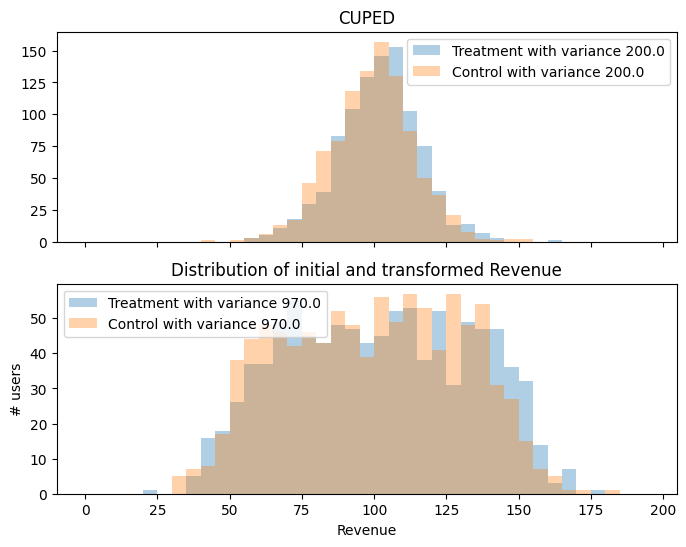

In [43]:
import matplotlib.pyplot as plt

var_Y = np.var(df['revenue_exp'])
var_Y_cuped = np.var(df['revenue_cuped'])

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True)

# Top subplot
axes[0].hist(df[df['group'] == 'treatment']['revenue_cuped'], 
         alpha=0.35,
         bins = np.arange(0.0, 200.0, 5.0),
         label= f'Treatment with variance {np.round(var_Y_cuped,-1)}')

axes[0].hist(df[df['group'] == 'control']['revenue_cuped'], 
         alpha=0.35,
         bins = np.arange(0.0, 200.0, 5.0),
         label= f'Control with variance {np.round(var_Y_cuped,-1)}')

axes[0].set_title('CUPED')
axes[0].legend()


# Bottom subplot
axes[1].hist(df[df['group'] == 'treatment']['revenue_exp'], 
         alpha=0.35,
         bins = np.arange(0.0, 200.0, 5.0),
         label= f'Treatment with variance {np.round(var_Y,-1)}')

axes[1].hist(df[df['group'] == 'control']['revenue_exp'], 
         alpha=0.35,
         bins = np.arange(0.0, 200.0, 5.0),
         label= f'Control with variance {np.round(var_Y,-1)}')

axes[1].set_title('Initial')
axes[1].legend()

plt.xlabel('Revenue')
plt.ylabel('# users')

plt.title('Distribution of initial and transformed Revenue')

plt.savefig('distribution.png', bbox_inches='tight', dpi=100)

In [44]:
treatment_cuped = df.loc[ df['group'] == 'treatment','revenue_cuped']
control_cuped = df.loc[ df['group'] == 'control','revenue_cuped']
t_stat, p_value = stats.ttest_ind(treatment_cuped, control_cuped)
print(f'Using CUPED the treatment effect is: {CUPED_ATE} with p_value {p_value}')

Using CUPED the treatment effect is: 2.235382942280424 with p_value 0.0005048596257247894


In [45]:
treatment = df.loc[ df['group'] == 'treatment','revenue_exp']
control = df.loc[ df['group'] == 'control','revenue_exp']
t_stat, p_value = stats.ttest_ind(treatment, control)
print(f'Without CUPED, the treatment effect is: {normal_ATE} with p_value {p_value}')

Without CUPED, the treatment effect is: 2.3194479700755295 with p_value 0.0984213053558601


## Minimum sample size calculation

To perform MSS using CUPED, we need historical data of the population and divide it into a fake experiment period and a fake pre-experiment period. THe calculation gives a minimum smaple size if the experiment had been performed during that time.

In [62]:
fake_data_MSS = pd.DataFrame([
    {'user_id' : '1', 'revenue': 2, 'date': '2024-01-01'},
    {'user_id' : '2', 'revenue': 2, 'date': '2024-01-01'},
    {'user_id' : '3', 'revenue': 22, 'date': '2024-01-01'},
    {'user_id' : '1', 'revenue': 2, 'date': '2024-07-01'},
    {'user_id' : '2', 'revenue': 3, 'date': '2024-07-01'},
    {'user_id' : '3', 'revenue': 20, 'date': '2024-07-01'}
])
fake_data_MSS['date'] = pd.to_datetime(fake_data_MSS['date'])

FAKE_EXPERIMENT_START_DATE = pd.to_datetime('2024-06-01')
CUPED_LOOKBACK_START_DATE = pd.to_datetime('2024-01-01')
EXPERIMENT_LENGTH = 12
FAKE_EXPERIMENT_END_DATE = FAKE_EXPERIMENT_START_DATE + relativedelta(weeks = EXPERIMENT_LENGTH)
MDE_PCNT = 0.10 # Minimum Detectable Effect
ALPHA = 0.2 # Type I error rate
BETA = 0.2 # Type II error rate

# calculate minimum sample size
Z_alpha = stats.norm.ppf(1-ALPHA/2)
Z_beta = stats.norm.ppf(1-BETA)
mde = MDE_PCNT*fake_data_MSS['revenue'].mean()

# sample variance of success metric during experiment
VAR_ABTEST = np.var(fake_data_MSS.loc[fake_data_MSS['date'] > FAKE_EXPERIMENT_START_DATE, 'revenue'],ddof=1)

# CUPED sample variance of success metric during experiment
correlation = np.corrcoef(
    fake_data_MSS.loc[fake_data_MSS['date'] > FAKE_EXPERIMENT_START_DATE, 'revenue'],
    fake_data_MSS.loc[fake_data_MSS['date'] < FAKE_EXPERIMENT_START_DATE, 'revenue']
    )[0,1]

VAR_CUPED = VAR_ABTEST*(1-correlation**2)

MSS_CUPED = (2*VAR_CUPED*(Z_alpha+Z_beta)**2)/(mde**2)
print(f"The CUPED minimum sample size is {np.round(MSS_CUPED,0)}")

The CUPED minimum sample size is 3.0
